<img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/banner-spectral.png" width="1000" align="middle"/>


# <font color='#ECA702'>**Hands-on Sesión 4: Clasificacion espectral 📸 🌈**</font>

# <font color='#4C5FDA'>**Objetivo**</font>



El objetivo de la clasificación hiperespectral es clasificar cada píxel/punto de datos en una de $K$ clases.  En general, los métodos de clasificación son más eficaces que los de desmezcla hiperespectral. Sin embargo, los métodos de clasificación no son eficaces a la hora de determinar las cantidades de proporción subpíxel o la cantidad de un material que puede encontrarse dentro del campo de visión correspondiente a un píxel.  

En general, los enfoques de clasificación hiperespectral implican:
1. (opcionalmente) extracción de características
2. aplicación de un clasificador estándar (es decir, clasificadores de la bibliografía sobre aprendizaje automático).

Para esta sesión haremos uso de 3 clasificadores comunes segun el estado del arte en la clasificacion espectral de imágenes

# <font color='#4C5FDA'>**Explicación métricas empleadas**</font>


- Precisión (Accuracy): La precisión es probablemente la métrica más directa y sencilla para entender. Imagina que tienes un conjunto de imágenes y un clasificador que intenta identificar si cada imagen contiene o no un perro. Si el clasificador evalúa 100 imágenes y acierta (correctamente identifica si hay o no un perro) en 90 de ellas, entonces la precisión del clasificador es del 90%. En términos matemáticos, la precisión se calcula como el número de predicciones correctas (tanto positivas como negativas) dividido por el número total de predicciones hechas. Se puede expresar como:

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/accuracy.png" alt="Imagenes espectrales" style="width: 400px;"/>
</div>

- Índice de Jaccard: El índice de Jaccard, también conocido como la Intersección sobre la Unión (IoU), es una medida un poco más sofisticada que se usa especialmente para evaluar la calidad de los clasificadores en tareas de segmentación de imágenes, donde no solo importa saber si una imagen contiene un objeto específico, sino también dónde está ese objeto dentro de la imagen.  Se calcula como la intersección (el área que ambos rectángulos, el predicho y el verdadero, comparten) dividida por la unión (el área total cubierta por ambos rectángulos, sin contar dos veces las áreas que se superponen). Esto se expresa matemáticamente como:

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/jaccard.webp" alt="Imagenes espectrales" style="width: 400px;"/>
</div>


**Al finalizar este Notebook deberas obtener una grafica comparativa con las predicciones de los tres clasificadores propuestos**

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/objetivo.png" alt="Imagenes espectrales" style="width: 700px;"/>
</div>

# <font color='#4C5FDA'>**Importamos datos necesarios**</font>

In [ ]:
# NO MODIFIQUES ESTA CELDA
!pip install gdown
!gdown --id 19Nq6zbBf3w7O98zM8J4Q_ITCdv8twAGn
!gdown --id 1IXMqFg3wxOaZM2hDPmQx1oOlXld2sf4R
!gdown --id 13kQVCwL5xrd1gdmdO-4fDnx5LTRsiZSu
!gdown --id 1-9DOllknc3R5LBecXHyq0CsxGhsB9nAD
!gdown --id 1-Yg_dHF6vIYFYE5iI5euySI5_fyeKr5i
!gdown --id 1-YgBzsuKCihvPgAy53-2nd1jtDZfwq-8
!gdown --id 1ceW10j7Puj3DvPTdO1IRLRnRe6KwlEqC
!gdown --id 1-EbDvtmyVPEFWXrGbln3YJAnkPR35rlA


# <font color='#4C5FDA'>**Importamos librerias**</font>

In [ ]:
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 50.8 MB/s eta 0:00:00


In [ ]:
from scipy.io import loadmat
import earthpy.spatial as es
import earthpy.plot as epp
import pandas as pd
import numpy as np
import warnings
import joblib
import seaborn as sns
import torch.nn.functional as F
import torch.utils.data as data_utils
import seaborn as sns
import torch
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score
from torch import nn
from torch import optim



sns.set()
warnings.filterwarnings("ignore")

## <font color='#4C5FDA'>**Información del Dataset**</font>

El conjunto de datos de la Universidad de Pavía es un conjunto de datos de imágenes hiperespectrales recogidas por un sensor conocido como espectrómetro de imágenes de sistema óptico reflectante (ROSIS-3) sobre la ciudad de Pavía, Italia. La imagen consta de 610×340 píxeles con 115 bandas espectrales. La imagen se divide en 9 clases con un total de 42.776 muestras etiquetadas, entre las que se incluyen el asfalto, los prados, la grava, los árboles, la chapa metálica, el suelo desnudo, el betún, el ladrillo y la sombra.

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/paviau.jpg" alt="Imagenes espectrales" style="width: 600px;"/>
</div>

# <font color='#4C5FDA'><small>**Cargamos el conjunto de datos**</small></font>

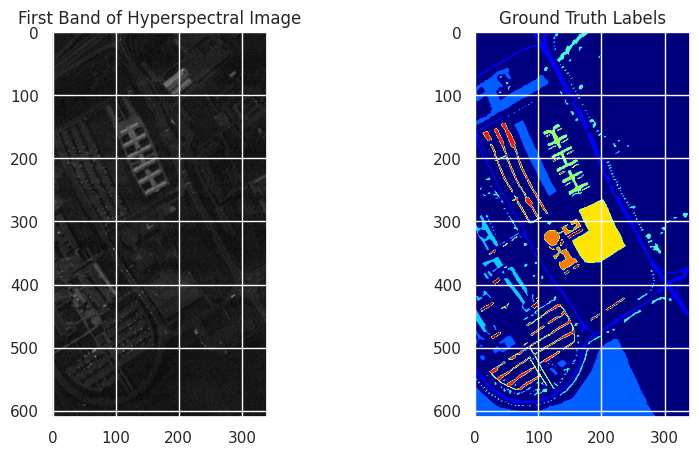

In [ ]:
def load_paviau_dataset(data_path, ground_truth_path):

    data = loadmat(data_path)
    gt = loadmat(ground_truth_path)

    # Assuming the variable names in the .mat files are 'paviaU' and 'paviaU_gt' respectively.
    # Adjust the keys if they are different in your dataset files.
    img = data['paviaU']
    gt = gt['paviaU_gt']

    return img, gt

# Funcion de preprocesamiento
def preprocess_data(img, gt):
    n_rows, n_cols, n_bands = img.shape
    pixels = img.reshape((n_rows*n_cols, n_bands))
    labels = gt.ravel()
    return pixels, labels

# Ejemplo de uso
data_path = 'PaviaU.mat'  
ground_truth_path = 'PaviaU_gt.mat'  
img, gt = load_paviau_dataset(data_path, ground_truth_path)

# Visualizar la primera banda de la imagen y la verdad fundamental para verificar
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 0], cmap='gray')
plt.title('First Band of Hyperspectral Image')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth Labels')
plt.show()


# <font color='#4C5FDA'><small>**Preparación de los datos para el clasificador KNN**</small></font>


Ahora podemos importar nuestro conjunto de datos de imágenes aéreas y convertirlo en un formato tabular para facilitar las operaciones de procesamiento sobre él. En este caso, cada banda de imagen se convierte en una columna **(¡tenemos más de 100 bandas!)**, y se crea una columna de clase para almacenar los datos sobre nuestras etiquetas, con cada objeto clasificado posible representado como un número (en total 10). Luego se eliminan los elementos asociados con la clase 0, ya que la clase 0 se ha utilizado como una categoría general para todos los objetos no clasificados en la imagen.

In [ ]:
# NO MODIFIQUES ESTA CELDA
n_rows, n_cols, n_bands = img.shape  # Obtiene las dimensiones de la imagen: filas, columnas y bandas espectrales
pixels = img.reshape((n_rows*n_cols, n_bands))  # Reorganiza la imagen en una matriz de píxeles (cada píxel con sus bandas espectrales)
labels = gt.ravel()  # Aplana el array de etiquetas del terreno para que coincida con la estructura de los píxeles
pixels, labels  # Muestra los arrays de píxeles y etiquetas

pixels, labels = preprocess_data(img, gt)  # Preprocesa los datos de la imagen y las etiquetas del terreno
# Filtra los píxeles que no tienen etiqueta en el terreno (etiquetas = 0)
pixels = pixels[labels > 0]  # Selecciona solo los píxeles con etiquetas de terreno
labels = labels[labels > 0]  # Selecciona solo las etiquetas correspondientes a esos píxeles

# Divide el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.3, random_state=42)  # Usa el 30% de los datos para prueba


# <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">1</font>** 💪</font>
* Construye el clasificador KNN, ayudate de la documentacion oficial en el siguiente enlace: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


In [ ]:
# Entrenar clasificador KNN
knn = KNeighborsClassifier(None)
knn.fit(None, None)

# Predecir en el conjunto de pruebas
y_pred = knn.predict(None)

In [ ]:
# Evaluacion
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Indice Jaccard: ", jaccard_score(y_test, y_pred, average='macro') )
print("Reporte de clasificacion:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusion:")
cf_matrix_knn = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix_knn, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g')

In [ ]:
# Salida esperada

# <font color='#4C5FDA'><small>**Entrenamiento del clasificador KNN usando todos los datos**</small></font>

In [ ]:
# NO MODIFIQUES ESTA CELDA
# Clasificar toda la imagen para su visualización
full_img_prediction = knn.predict(img.reshape((-1, img.shape[2])))
pred_knn = full_img_prediction.reshape((img.shape[0], img.shape[1]))
gt_flat = gt.ravel()
mask = gt_flat != 0
gt_filtered = gt_flat[mask]
full_img_prediction_filtered = full_img_prediction[mask]

print("Accuracy:", accuracy_score(gt_filtered, full_img_prediction_filtered))
print("Reporte de clasificacion:")
print(classification_report(gt_flat, full_img_prediction))

Accuracy: 0.9264307088086777
Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    164624
           1       0.17      0.93      0.28      6631
           2       0.24      0.99      0.39     18649
           3       0.24      0.81      0.37      2099
           4       0.13      0.90      0.22      3064
           5       0.44      1.00      0.61      1345
           6       0.11      0.77      0.19      5029
           7       0.43      0.88      0.58      1330
           8       0.22      0.90      0.35      3682
           9       0.09      1.00      0.16       947

    accuracy                           0.19    207400
   macro avg       0.21      0.82      0.32    207400
weighted avg       0.04      0.19      0.07    207400



# <font color='#4C5FDA'><small>**Graficar la prediccion del clasificador KNN**</small></font>

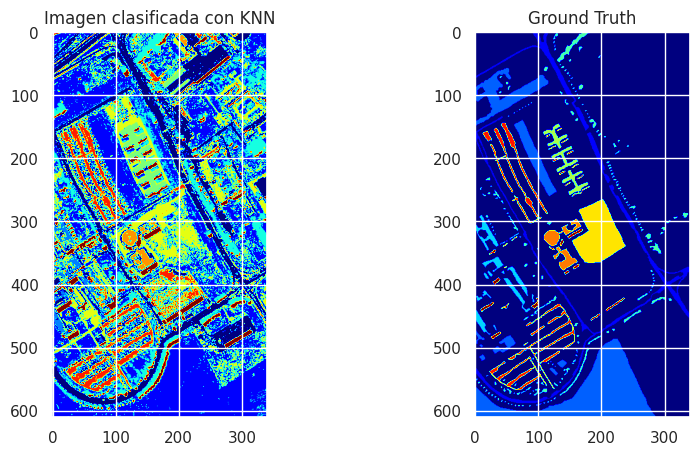

In [ ]:
# Trazar la imagen clasificada

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_knn, cmap='jet')
plt.title('Imagen clasificada con KNN')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth')
plt.show()

# <font color='#4C5FDA'><small>**Preprocesamiento para el clasificador Decision Tree**</small></font>

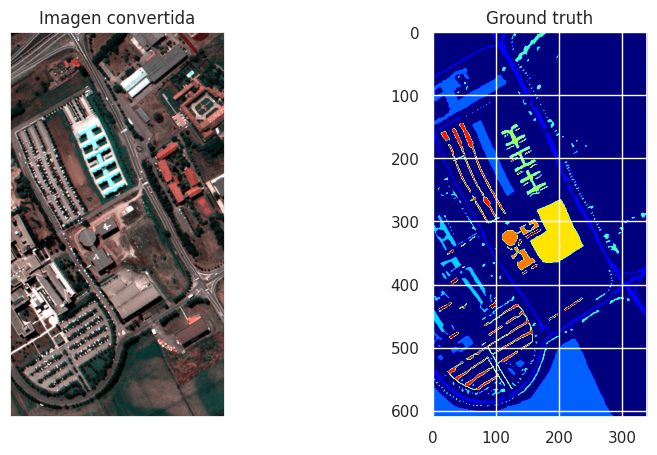

In [ ]:
# NO MODIFIQUES ESTA CELDA

df = pd.DataFrame(img.reshape(img.shape[0]*img.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()
df = df[df['class']!=0]

stacked_bands = np.transpose(img, (2, 0, 1))
sampled_bands = np.array([stacked_bands[0], stacked_bands[50], stacked_bands[100]])
bands = [f'Band {i}' for i in range(1, 102, 50)]
colors = list(mcolors.BASE_COLORS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
epp.plot_rgb(
    stacked_bands,
    rgb=(60, 30, 27),
    stretch=True,
    figsize=(10, 10),
    ax=plt.gca(),
)
plt.title('Imagen convertida')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground truth')
plt.show()

# <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">2</font>** 💪</font>
* Construye el clasificador Decision Tree, ayudate de la documentacion oficial en el siguiente enlace: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


In [ ]:
x = df.drop(['class'], axis=1) 
y = df['class']

le = preprocessing.LabelEncoder()
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, stratify = y)
y_encoder = le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

dt = DecisionTreeClassifier(random_state=0) 
model_dt = dt.fit(x_train.values, y_train)
y_pred = model_dt.predict(x_test.values)

In [ ]:
# Evaluacion
print("Accuracy Score: ", round(accuracy_score(y_test, y_pred), 3)*100, "%")
print("Indice Jaccard: ", jaccard_score(y_test, y_pred, average='macro'))
print("Reporte de clasificacion:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cf_matrix_dt = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix_dt, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g')

Accuracy Score:  88.5 %
Indice Jaccard:  0.7767875136209388
Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1989
           1       0.93      0.93      0.93      5595
           2       0.73      0.68      0.71       630
           3       0.90      0.91      0.91       919
           4       0.99      0.99      0.99       403
           5       0.79      0.80      0.80      1509
           6       0.76      0.77      0.77       399
           7       0.79      0.82      0.80      1105
           8       1.00      1.00      1.00       284

    accuracy                           0.88     12833
   macro avg       0.87      0.87      0.87     12833
weighted avg       0.88      0.88      0.88     12833

Confusion Matrix:


<Axes: >

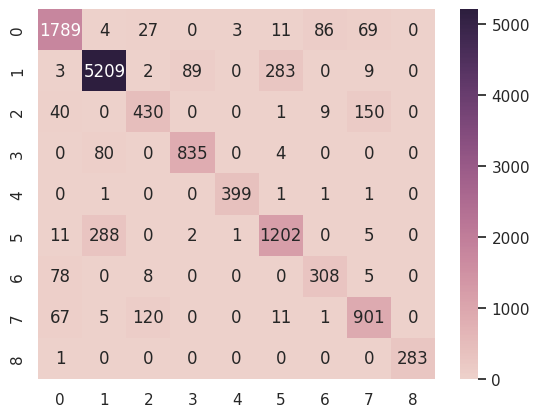

In [ ]:
# Salida esperada

# <font color='#4C5FDA'><small>**Entrenamiento del clasificador Decision Tree**</small></font>

In [ ]:
l = []
for i in range(img.shape[0]*img.shape[1]):
    if i in list(df.index):
        l.append(le.inverse_transform(model_dt.predict([df.loc[i, :][:-1]])))
    else:
        l.append(0)

pred_dt = np.array(l, dtype=object).reshape(gt.shape).astype('float')

# <font color='#4C5FDA'><small>**Graficar la prediccion del clasificador Decision Tree**</small></font>

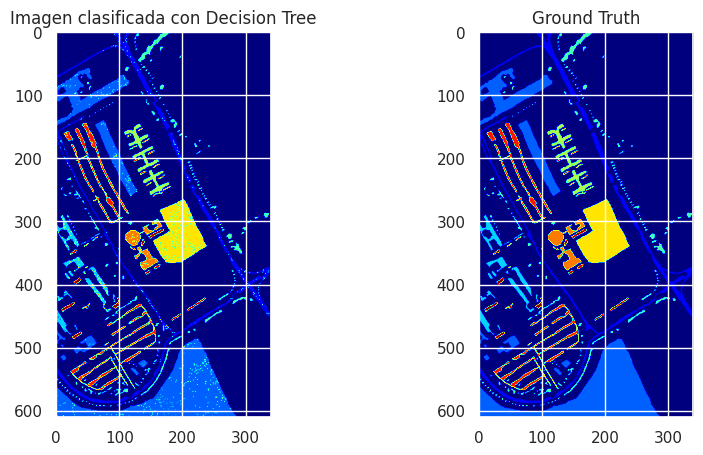

In [ ]:
# Trazar la imagen clasificada

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_dt, cmap='jet')
plt.title('Imagen clasificada con Decision Tree')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth')
plt.show()

# <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">3</font>** 💪</font>
* Evalúa el modelo de redes neuronales que implementamos para que visualices los resultados de esta clasificación.


# <font color='#4C5FDA'><small>**Declaracion del modelo**</small></font>

In [ ]:
# NO MODIFIQUES ESTA CELDA

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.cv1 = nn.Conv3d(1, 8, kernel_size=(3,3, 5))
        self.cv2 = nn.Conv2d(8, 16, kernel_size=(3,3))
        self.fc1 = nn.Linear(100048, 128)
        self.dp = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.cv1(x)
        out = F.relu(out)
        out = torch.reshape(out, (out.shape[0], out.shape[1], out.shape[2], out.shape[3]*out.shape[4]))
        out = self.cv2(out)
        out = F.relu(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.dp(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
def zeros_pad(x, margin):
    padded_x = torch.zeros((x.shape[0] + 2 * margin, x.shape[1] + 2 * margin, x.shape[2]))
    padded_x[margin:x.shape[0] + margin, margin:x.shape[1] + margin, :] = x
    return padded_x

def create_image(x, y, window_size):
    margin = (window_size - 1) // 2
    padded_x = zeros_pad(x, margin=margin)
    patched_x = torch.zeros((x.shape[0] * x.shape[1], window_size, window_size, x.shape[2]))
    patched_y = torch.zeros((x.shape[0] * x.shape[1]))
    patch_index = 0
    for i in range(margin, padded_x.shape[0] - margin):
        for j in range(margin, padded_x.shape[1] - margin):
            patch = padded_x[i - margin:i + margin + 1, j - margin:j + margin + 1]
            patched_x[patch_index, :, :, :] = patch
            patched_y[patch_index] = y[i-margin, j-margin]
            patch_index += 1
    patched_x = patched_x[patched_y>0,:,:,:]
    patched_y = patched_y[patched_y>0]
    patched_y -= 1
    return patched_x, patched_y

# <font color='#4C5FDA'><small>**Cargamos los modelos necesarios**</small></font>

In [ ]:

# Cargar el modelo de Deep Learning completo
model = torch.load('complete_model.pth')
model.eval()

CNNModel(
  (cv1): Conv3d(1, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1))
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=100048, out_features=128, bias=True)
  (dp): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [ ]:
# Cargar el modelo PCA
pca = joblib.load('model_pca.pkl')

# Cargar los conjuntos de datos particionados
cnn_x_train = torch.load('cnn_x_train.pth')
cnn_x_test = torch.load('cnn_x_test.pth')
cnn_y_train = torch.load('cnn_y_train.pth')
cnn_y_test = torch.load('cnn_y_test.pth')

In [ ]:
dimensions = 17
window_size = 25
test_perc = 0.3

# Aquí realizamos la creación de DataLoader para la evaluación
# No necesitas aplicar PCA de nuevo, ya que los datos ya están transformados y listos para usarse
test = torch.utils.data.TensorDataset(cnn_x_test, cnn_y_test)
testloader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

# <font color='#4C5FDA'><small>**Ejecuta las siguientes 2 celdas para evaluar el modelo pre-entrenado**</small></font>

In [ ]:
# NO MODIFIQUES ESTA CELDA
def confusion_matrix(data, nb_classes):
    df_cm = pd.DataFrame(data,
                          range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues',
                fmt='g')
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel("Predicted Output", fontsize = 18)
    plt.ylabel("Expected Output", fontsize = 18)
    plt.show()

def acc_per_class(model, testloader, nb_classes):
    model.eval()
    confusion_mat = torch.zeros(nb_classes, nb_classes)
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    total = 0
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_mat[t.long(), p.long()] += 1

    confusion_matrix(confusion_mat.data.cpu().numpy(), nb_classes)

    per_class_acc = 100*confusion_mat.diag()/confusion_mat.sum(1)
    for i, j in enumerate(per_class_acc.data.cpu().numpy()):
        print("Class:", i, "Accuracy:", j)
    acc = torch.mean(per_class_acc).data.cpu().numpy()
    print("Overall Accuracy: ", acc, "%")

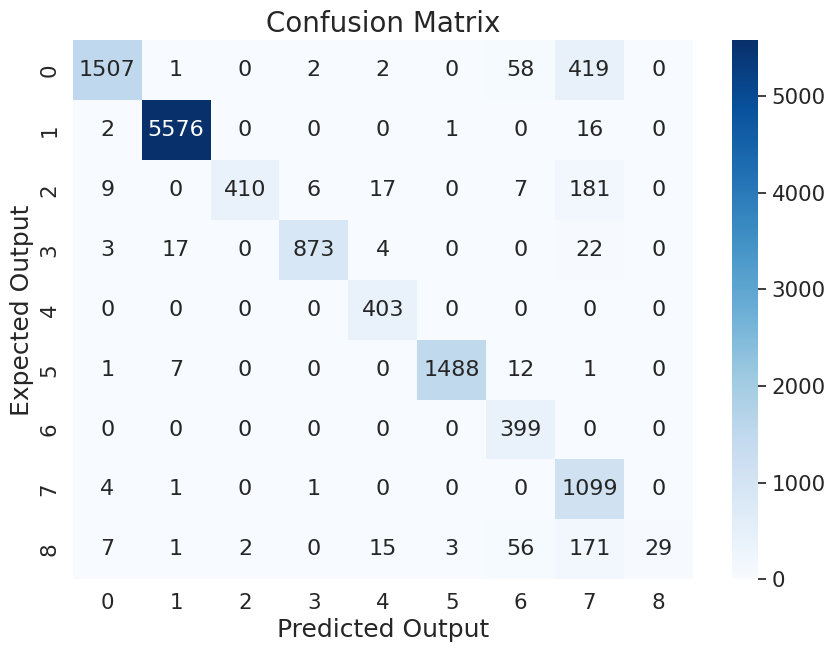

Class: 0 Accuracy: 75.766716
Class: 1 Accuracy: 99.66041
Class: 2 Accuracy: 65.07937
Class: 3 Accuracy: 94.99456
Class: 4 Accuracy: 100.0
Class: 5 Accuracy: 98.60835
Class: 6 Accuracy: 100.0
Class: 7 Accuracy: 99.457016
Class: 8 Accuracy: 10.211267
Overall Accuracy:  82.64197 %


In [ ]:
# NO MODIFIQUES ESTA CELDA
x = np.reshape(img, (-1, img.shape[2]))
x_pca = pca.fit_transform(x)
x_pca = np.reshape(x_pca, (img.shape[0], img.shape[1], dimensions))
padded_x = zeros_pad(torch.tensor(x_pca), window_size//2)

pred = np.zeros((gt.shape[0], gt.shape[1]))
for h in range(gt.shape[0]):
    for w in range(gt.shape[1]):
        if int(gt[h, w]) == 0:
            continue
        else:
            model.eval()
            image_patch = padded_x[h:h+window_size, w:w+window_size, :]
            image = torch.permute(image_patch[None, None, :, :, :], (0, 1, 4, 2, 3))
            pred[h][w] = model(image).argmax(dim=1) + 1

acc_per_class(model, testloader, 9)


# <font color='#4C5FDA'><small>**Ejecuta la siguiente celda para obtener el Índice de Jaccard**</small></font>

In [ ]:
# NO MODIFIQUES ESTA CELDA
def jaccard_coefficient(pred, gt, nb_classes):
    jaccard_per_class = np.zeros(nb_classes)
    for cls in range(1, nb_classes + 1):  # Class labels start from 1
        pred_cls = pred == cls
        gt_cls = gt == cls
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()
        if union == 0:
            jaccard_per_class[cls - 1] = np.nan  # To handle division by zero
        else:
            jaccard_per_class[cls - 1] = intersection / union
    return np.nanmean(jaccard_per_class), jaccard_per_class  # Return average and per-class Jaccard

In [ ]:
nb_classes = 9  # Número de clases
avg_jaccard, jaccard_per_class = jaccard_coefficient(pred, gt, nb_classes)
print("Average Jaccard Coefficient:", avg_jaccard)
print("Jaccard Coefficient per Class:", jaccard_per_class)

Average Jaccard Coefficient: 0.7564105313039867
Jaccard Coefficient per Class: [0.7694258  0.99305556 0.70819517 0.93919793 0.92060233 0.97898493
 0.75611143 0.59385666 0.14826498]


# <font color='#4C5FDA'><small>**Graficar la prediccion del clasificador con Deep Learning**</small></font>

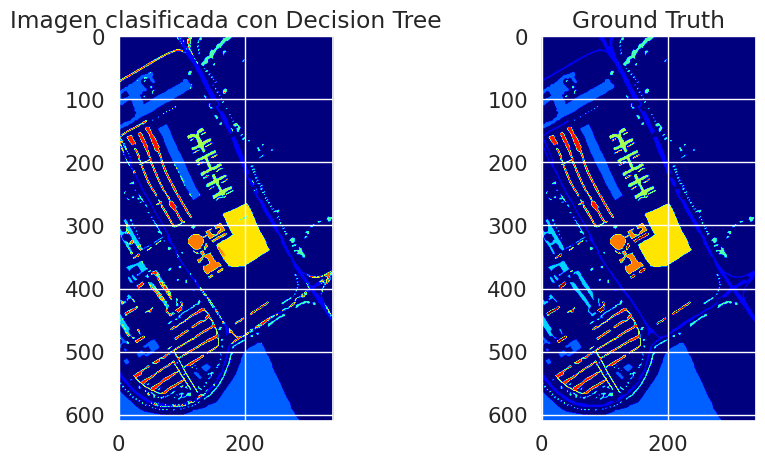

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred, cmap='jet')
plt.title('Imagen clasificada con Deep Learning')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth')
plt.show()

# **<font color="#FF0000">E</font><font color="#FF7F00">x</font><font color="#FFFF00">t</font><font color="#00FF00">r</font><font color="#0000FF">a</font>**: Grafica los tres resultados de los tres clasificadores y compara los resultados de manera visual. ¿Cual crees que es el mejor clasificador y por qué?

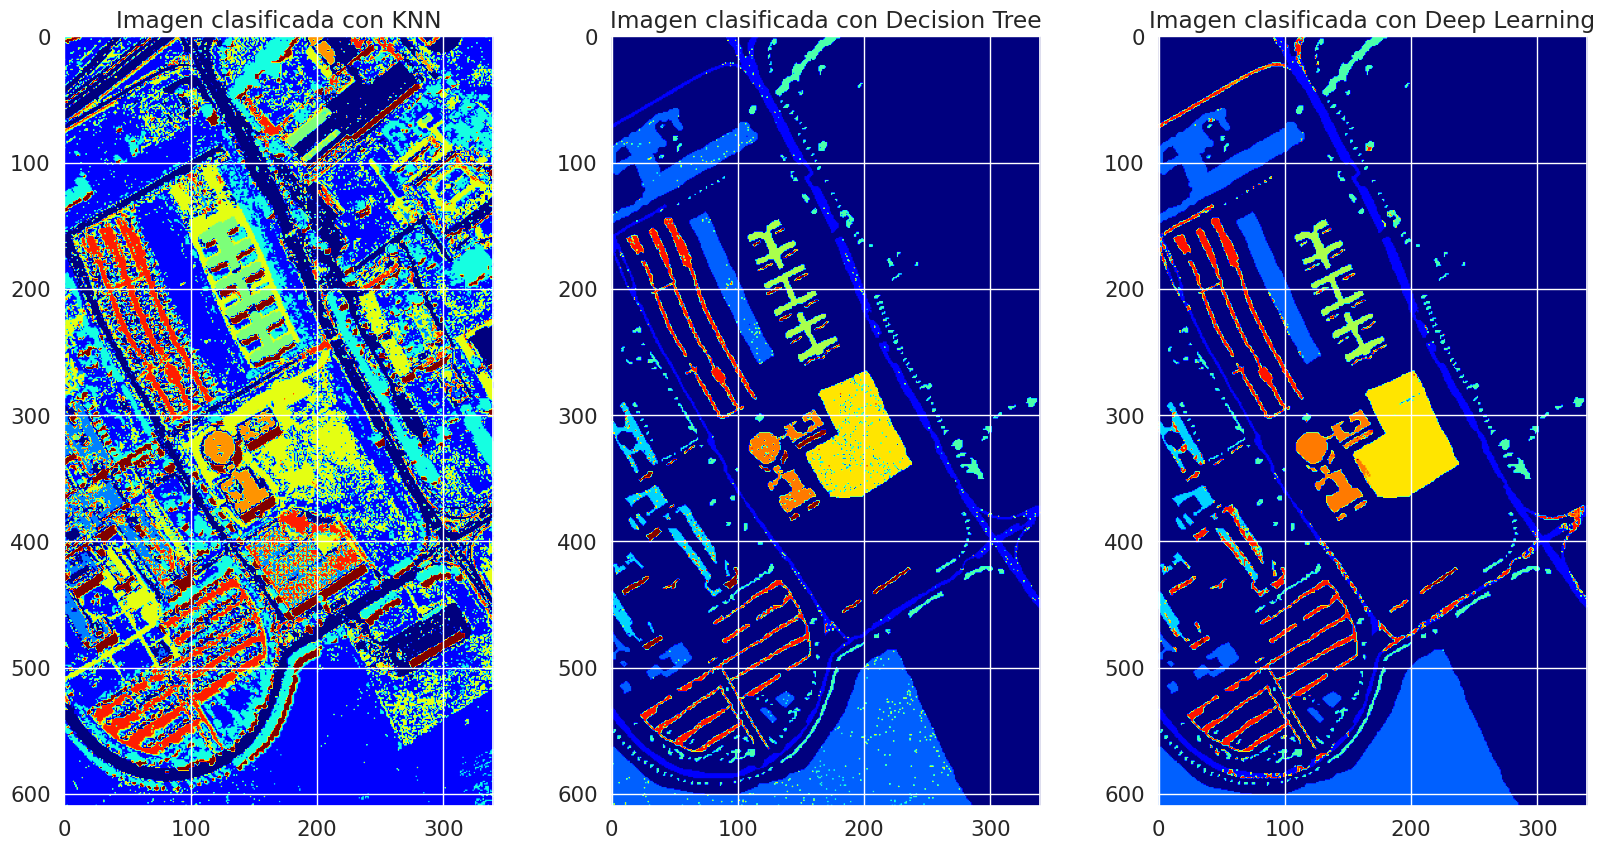

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(pred_knn, cmap='jet')
plt.title('Imagen clasificada con KNN')
plt.subplot(1, 3, 2)
plt.imshow(pred_dt, cmap='jet')
plt.title('Imagen clasificada con Decision Tree')
plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='jet')
plt.title('Imagen clasificada con Deep Learning')
plt.show()